In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt

In [2]:
class MultiHeadSelfAttention(nn.Module):
    """Multi-Head Self-Attention(マルチヘッド自己注意機構)

    Attributes:
        num_heads: マルチヘッドのヘッド数
        expansion_layer: 特徴マップの各要素のサイズを×3するための全結合層
        headjoin_layer: 各ヘッドから出力された特徴表現を線形変換する全結合層
        scal: ソフトマックス関数入力前に適用するスケール値
    """
    def __init__(self,
                 num_inputlayer_units: int,
                 num_heads: int):
        super().__init__()
        """マルチヘッドアテンションに必要なレイヤー等の定義

        Args:
            num_inputlayer_units(int): 全結合層(線形層)のユニット数
            num_heads(int) : マルチヘッドアテンションのヘッド数
        """
        # 特徴マップの特徴量の数をヘッドの数で分割できるか確認
        if num_inputlayer_units % num_heads != 0:
            raise ValueError("num_inputlayer_units must be divisible by num_heads")
        # ヘッドの数を設定
        self.num_heads = num_heads
        # 特徴マップ生成機構の全結合層ユニット数をヘッドの数で割ることで
        # ヘッドごとの特徴量の次元を求める
        dim_head = num_inputlayer_units // num_heads

        # データ拡張を行う全結合層の定義
        # 入力の次元数: 特徴マップの特徴量次元
        # 出力の次元数(ユニット数): 特徴量次元×3
        self.expansion_layer = nn.Linear(
            num_inputlayer_units,     # 入力サイズは特徴マップの特徴量次元と同じ
            num_inputlayer_units * 3) # ユニット数は特徴量次元×3

        # ソフトマックス関数のオーバーフロー対策のためのスケール値
        # 次元数の平方根の逆数（1/sqrt(dimension)）
        self.scale = 1 / (dim_head ** 0.5)

        # 各ヘッドからの出力を線形変換後に結合する全結合層の定義
        # 入力の次元数: ヘッドごとの特徴量次元＝特徴マップ生成機構の全結合層ユニット数
        # 出力の次元数(ユニット数): 入力の次元数と同じ
        self.headjoin_layer = nn.Linear(
            num_inputlayer_units,
            num_inputlayer_units)

    def forward(self, x: torch.Tensor):
        """順伝播処理を行う

        Args:
            x(torch.Tensor): 特徴マップ(バッチサイズ, 特徴量数, 特徴量次元)
        """
        # 入力する特徴マップのテンソル(バッチサイズ, 5, 512)から
        # バッチサイズと特徴マップの特徴量の数(クラストークン数+パッチ数)を取得
        bs, ns = x.shape[:2]

        # 全結合層expansion_layerに入力してデータを拡張
        # 入力: (バッチサイズ, 5, 512)
        # 出力: (バッチサイズ, 5, 1536[512×3])
        qkv = self.expansion_layer(x)

        # view()の処理
        # データ拡張したテンソル(バッチサイズ, 5, 1536)を
        # クエリ行列、キー行列、バリュー行列に分割→(バッチサイズ, 5, 3, 512)
        # さらに各行列をマルチヘッドの数に分割→(バッチサイズ, 5, 3, 4(ヘッド数), 128(特徴量次元))
        #
        # permute()の処理
        # クエリ,キー,バリューの次元をテンソルの先頭に移動して
        # (3, バッチサイズ, ヘッド数, 特徴量数, 特徴量次元)の形状にする
        # この並べ替えにより、クエリ,キー,バリューが別々の次元に配置される
        # 処理後のテンソルの形状: (3, バッチサイズ, 4, 5, 128)
        qkv = qkv.view(
            bs, ns, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)

        # クエリ行列(q),キー行列(k),バリュー行列(v)に分割
        # q,k,vそれぞれの形状は(バッチサイズ, ヘッド数(4), 特徴量の数(5), 128)
        # それぞれヘッドの数に分割されている
        q, k, v = qkv.unbind(0)

        # ヘッドごとのクエリの行列(5, 128)と転置したキーの行列(128,5)の行列積(内積)を計算し、
        # 各要素間の関連度(アテンションスコア)を求める、結果のテンソルの形状は(5,5)
        # attnの形状は(バッチサイズ, ヘッド数(4), 特徴量の数(5), 特徴量の数(5))
        attn = q.matmul(k.transpose(-2, -1))

        # アテンションスコアの行方向にソフトマックス関数を適用して
        # スコアの合計値が1.0になるように正規化を行う
        attn = (attn * self.scale).softmax(dim=-1)

        # アテンションスコアattn(バッチサイズ(32), ヘッド数(4), 特徴量数(5), 特徴量数(5))と
        # バリュー(32, 4, 5, 128)の行列積を計算
        # 各ヘッドごとにアテンションスコア(5,5)とバリュー行列(5,128)の行列積
        # xの形状は(バッチサイズ, ヘッド数(4), 特徴量数(5), 特徴量次元(128))
        x = attn.matmul(v)

        # permute()の処理
        # (バッチサイズ, ヘッド数(4), 特徴量数(5), 特徴量次元(128))を
        # (バッチサイズ, 特徴量数(5), ヘッド数(4), ヘッドの特徴量次元)に並べ替える
        # flatten()でヘッドごとに得られる特徴量次元を結合
        # xの形状は(バッチサイズ, 特徴量数(5), ヘッド数(4)×特徴量次元(512))
        x = x.permute(0, 2, 1, 3).flatten(2)

        # 全結合層headjoin_layerに入力
        # 入力テンソル:(32, 5, 512)
        # 出力テンソル:(32, 5, 512)
        x = self.headjoin_layer(x)

        return x


In [3]:
class MLP(nn.Module):
    """多層パーセプトロンの定義

    Transformerエンコーダー内のMulti-Head Self-Attention機構に続く全結合型2層
    Attributes:
        linear1: 隠れ層
        linear2: 出力層
        activation: 活性化関数
    """
    def __init__(self,
                 num_inputlayer_units: int,
                 num_mlp_units: int):
        """2層の全結合層を定義

        Args:
            num_inputlayer_units(int): 特徴マップ生成時の全結合層のユニット数
            num_mlp_units(int): 多層パーセプトロンのユニット数
        """
        super().__init__()
        # 隠れ層
        self.linear1 = nn.Linear(num_inputlayer_units, num_mlp_units)
        # 出力層
        self.linear2 = nn.Linear(num_mlp_units, num_inputlayer_units)
        # 活性化関数はGELU
        self.activation = nn.GELU()

    def forward(self, x: torch.Tensor):
        """順伝播処理を行う

        Args:
        x(torch.Tensor): 特徴マップ(バッチサイズ, 特徴量数, 特徴量次元)
        """
        x = self.linear1(x)
        x = self.activation(x) # 隠れ層のみ活性化関数を適用
        x = self.linear2(x)

        return x


In [4]:
class EncoderBlock(nn.Module):
    """ EncoderBlockの定義

    Attributes:
        attention: Multi-Head Self-Attention(マルチヘッド自己注意機構)
        mlp: 2層構造の多層パーセプトロン
        norm1: 先頭に配置する正規化層
        norm2: Multi-Head Self-Attentionの直後に配置する正規化層
    """
    def __init__(self,
                 num_inputlayer_units: int,
                 num_heads: int,
                 num_mlp_units: int):
        """
        Args:
            num_inputlayer_units(int): 特徴マップ生成時の全結合層のユニット数
            num_heads(int) : マルチヘッドアテンションのヘッド数
            num_mlp_units(int): 多層パーセプトロンのユニット数
        """
        super().__init__()
        # MultiHeadSelfAttentionを生成
        self.attention = MultiHeadSelfAttention(num_inputlayer_units, num_heads)
        # MLPを生成
        self.mlp = MLP(num_inputlayer_units, num_mlp_units)
        # LayerNormを生成
        self.norm1 = nn.LayerNorm(num_inputlayer_units)
        self.norm2 = nn.LayerNorm(num_inputlayer_units)

    def forward(self, x: torch.Tensor):
        """順伝播処理を行う

        Args:
            x(torch.Tensor): 特徴マップ(バッチサイズ, 特徴量数, 特徴量次元)
        """
        x = self.norm1(x)          # 正規化層
        x = self.attention(x) + x  # 残差接続
        x = self.norm2(x)          # 正規化層
        x = self.mlp(x) + x        # 残差接続

        return x


In [5]:
class VisionTransformer(nn.Module):
    """VisionTransformerモデル

    Attributes:
        img_size: 入力画像の1辺のサイズ(幅と高さは等しい)
        patch_size: パッチの1辺のサイズ(幅と高さは等しい)
        input_layer: パッチデータを線形変換する全結合層
        pos_embed: 位置情報
        class_token: クラストークン
        encoder_layer: Encoder
        normalize: 分類器の正規化層
        output_layer: 分類器の全結合層
    """
    def __init__(
            self,
            num_classes: int,
            img_size: int,
            patch_size: int,
            num_inputlayer_units: int,
            num_heads: int,
            num_mlp_units: int,
            num_layers: int):
        """レイヤー（層）の定義

        Args:
            num_classes(int): 画像分類のクラス数
            img_size(int): 入力画像の1辺のサイズ(幅と高さは等しい)
            patch_size(int): パッチの1辺のサイズ(幅と高さは等しい)
            num_inputlayer_units(int): 全結合層(線形層)のユニット数
            num_heads(int): マルチヘッドアテンションのヘッド数
            num_mlp_units(int): MLP各層のユニット数
            num_layers(int): Encoderに格納するEncoderBlockの数
        """
        super().__init__()
        # ----------特徴マップ生成機構①(パッチへの分割)----------
        # 画像サイズとパッチサイズのインスタンス変数を初期化
        self.img_size = img_size
        self.patch_size = patch_size

        # img_size(画像の1辺のサイズ) // patch_size（パッチの1辺のサイズ)
        # で求めた値を2乗してパッチの数を求める
        # img_size=32, patch_size=16の場合は、num_patches=4
        num_patches = (img_size // patch_size) ** 2

        # 画像から切り出される各パッチのピクセルデータ数を計算
        # patch_size=16の場合は16**2=256
        # カラー画像がRGB（赤、緑、青）の3つのチャンネルを持っているので
        # ピクセルデータ数は256×3=768になる
        input_dim = 3 * patch_size ** 2

        # パッチに分割し、フラット化された特徴量を線形変換する全結合層を定義
        # 入力(768(ピクセルデータ),)
        # 全結合層のユニット数: 512を想定
        self.input_layer = nn.Linear(input_dim, num_inputlayer_units)

        # ----特徴マップ生成機構②(クラストークン、位置情報埋め込み)----
        # クラストークンの定義
        # 3階テンソル(1, 1, 512)を作成し、平均0、標準偏差1の正規分布から
        # ランダムサンプリングして初期化
        # nn.Parameter()で学習可能なパラメーターとして定義する
        self.class_token = nn.Parameter(
            torch.randn(1, 1, num_inputlayer_units))

        # 位置情報の定義
        # (1, パッチ数 + 1(クラストークン), 全結合層のユニット数)のテンソルを作成し、
        # 平均0、標準偏差1の正規分布からランダムサンプリングして初期化
        # nn.Parameter()で学習可能なパラメーターとして定義する
        self.pos_embed = nn.Parameter(
            torch.randn(1, num_patches + 1, num_inputlayer_units))

        # ----------Encoderの定義----------
        # EncoderBlockをnum_layersの数だけ生成
        self.encoder_layer = nn.ModuleList(
            [EncoderBlock(
                num_inputlayer_units, num_heads, num_mlp_units
                ) for _ in range(num_layers)])

        # ----------分類器-----------------
        # 正規化層の入力次元数は特徴マップ生成機構の全結合層のユニット数
        self.normalize = nn.LayerNorm(num_inputlayer_units)
        # 正規化層からの入力をnum_classesの数のユニットで処理
        self.output_layer = nn.Linear(num_inputlayer_units, num_classes)

    def forward(self, x: torch.Tensor):
        """順伝播処理を行う

        Args:
            x(torch.Tensor): 画像データ、1枚の画像の形状は(32,3,32,32)
        """
        # ----------特徴マップ生成機構の適用----------
        # 入力データ(ミニバッチサイズ, チャンネル数, 画像行数, 画像列数)
        # から各次元の要素数を取得 --> bs=32, c= 3, h=32, w= 32
        bs, c, h, w = x.shape

        # 1枚の画像データを4個のパッチに分割する処理
        # 入力される4階テンソルの形状(バッチサイズ, チャンネル数, 画像行数,, 画像列数)
        # 画像の行方向のデータ(32px)をパッチサイズ(16px)で割った数2に分割
        # 画像の列方向のデータ(32px)をパッチサイズ(16px)で割った数2に分割
        # 画像の行、列データを2ずつ分割したことで
        # 6階テンソル(バッチサイズ, 3, 2, 16, 2, 16)が出力される
        x = x.view(
            bs,
            c,
            h // self.patch_size, # 行方向にパッチがいくつ入るかを計算
            self.patch_size, # パッチごとに行方向のデータを格納
            w // self.patch_size, # 列方向にパッチがいくつ入るかを計算
            self.patch_size) # パッチごとに列方向のデータを格納

        # パッチに分割した6階テンソル(32, 3, 2, 16, 2, 16)の次元を並べ替える
        # (バッチサイズ,チャンネル数,行パッチ数,パッチの行データ,列パッチ数,パッチの列データ)を
        # (バッチサイズ,行パッチ数,列パッチ数,チャンネル数,パッチの行データ,パッチの列データ)
        # に変換 → (バッチサイズ, 2, 2, 3, 16, 16)が出力される
        x = x.permute(0, 2, 4, 1, 3, 5)

        # 画像1枚のパッチ4個のピクセルデータをそれぞれフラット化する
        # 3階テンソル(バッチサイズ, 1枚あたりのパッチ数, パッチデータ)にする
        # (バッチサイズ, 2×2=4(パッチ数), 16×16×3=768(パッチごとのピクセルデータ))
        x = x.reshape(bs, (h // self.patch_size) * (w // self.patch_size), -1)

        # 全結合層(768ユニット)にxを入力して線形変換後、512ユニットを出力
        # 入力: (バッチサイズ, 4, 768)
        # 出力: (バッチサイズ, 4, 512)
        x = self.input_layer(x)

        # クラストークンのテンソル(1,512)をミニバッチの数だけ作成
        class_token = self.class_token.expand(bs, -1, -1)
        # クラストークン(バッチサイズ, 1, 512)を
        # 全結合層からの出力(バッチサイズ, 4, 512)の1の次元の先頭位置で連結
        # テンソルの形状は(バッチサイズ, 5, 512)になる
        x = torch.cat((class_token, x), dim=1)

        # クラストークンが追加された(バッチサイズ, 5, 512)の形状のテンソルに
        # 学習可能な位置情報のテンソル(1, 5, 512)の学習可能なパラメーター値を加算
        x += self.pos_embed

        # EncoderBlockで処理
        for layer in self.encoder_layer:
            x = layer(x)

        # Encoderで処理後の特徴マップからクラストークンを抽出
        x = x[:, 0]
        # 正規化層に入力
        x = self.normalize(x)
        # 10ユニットの全結合層に入力
        x = self.output_layer(x)

        # 戻り値は要素数10のベクトル
        return x


    def get_device(self):
        """最終の全結合層を処理中のデバイスを返す関数
        """
        return self.output_layer.weight.device


In [6]:
def evaluate(data_loader, model, loss_func):
    """検証を行う

    Args:
        data_loader(DataLoader): テスト用のデータローダー
        model(nn.Module): VisionTransformerモデル
        loss_func(nn.functional): 損失関数
    """
    # モデルを評価モードに切り替え
    model.eval()

    device = next(model.parameters()).device  # モデルのデバイスを取得

    total_loss = 0.0  # 総損失を格納する変数
    correct_preds = 0  # 正解の数をカウントする変数
    total_samples = 0  # 処理されたデータ数をカウントする変数

    # データローダーからバッチ単位でデータを抽出し、学習中のモデルで検証
    for x, y in data_loader:
        # 勾配の計算をオフにして計算リソースを節約
        with torch.no_grad():
            # バッチの入力データx、ターゲットデータyをモデルのデバイスに配置
            x = x.to(device)
            y = y.to(device)
            # 入力データ x を使ってモデルによる予測を行う
            preds = model(x)
            # 予測結果predsとターゲットラベルyを使用して損失を計算
            loss = loss_func(preds, y)
            # 総損失に加算
            total_loss += loss.item() * y.size(0)

            # 最大値のインデックスを取得し、正確な予測の数をカウント
            _, predicted = torch.max(preds, 1)
            correct_preds += (predicted == y).sum().item()
            # 処理されたデータ数をカウント
            total_samples += y.size(0)

    # 全体の損失は、総損失を全データ数で割る
    average_loss = total_loss / total_samples if total_samples > 0 else 0.0
    # 精度は、正確な予測の数を全データ数で割ることで求める
    accuracy = correct_preds / total_samples if total_samples > 0 else 0.0

    return average_loss, accuracy


In [7]:
class ModelConfig:
    """パラメーターの初期値を設定

    """
    def __init__(self):
        self.num_epochs = 50 # 学習回数(エポック数)
        self.batch_size = 32 # ミニバッチのサイズ
        self.lr = 0.01 # 学習率
        self.img_size = 32 # 画像の1辺のサイズ(縦横同サイズ)
        self.patch_size = 16 # パッチの1辺のサイズ
        self.num_inputlayer_units = 512 #  特徴マップ生成機構における全結合層のユニット数
        self.num_heads = 4 # Multi-Head Self-Attentionのヘッド数
        self.num_mlp_units = 512 # Encoderブロック内MLPのユニット数
        self.num_layers = 6 # Encoderブロックの数


In [8]:
# ModelConfigクラスをインスタンス化
config = ModelConfig()

# CIFAR-10データセットの平均と標準偏差を用いて
# 各チャンネルのデータを標準化する変換器を作成
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
# 訓練データの正規化を行う変換器
train_transform = transforms.Compose([transforms.ToTensor(), normalize])
# テストデータの正規化を行う変換器
test_transform = transforms.Compose([transforms.ToTensor(), normalize])

# 訓練用データセットの用意
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform)
# 検証用データセットの用意
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform)

# 訓練データ用のDataLoaderを作成
train_loader = DataLoader(
    train_dataset, batch_size=config.batch_size, shuffle=True)
# 検証データ用のDataLoaderを作成
test_loader = DataLoader(
    test_dataset, batch_size=config.batch_size, shuffle=False)

# クロスエントロピー誤差関数の生成
loss_func = F.cross_entropy

# Vision Transformerモデルの生成
model = VisionTransformer(
    len(train_dataset.classes), config.img_size, config.patch_size,
    config.num_inputlayer_units, config.num_heads,
    config.num_mlp_units, config.num_layers)

# オプティマイザー(最適化器)の生成
optimizer = optim.SGD(model.parameters(), lr=config.lr)
# 使用可能なデバイス(GPU)を取得
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# モデルに使用可能なデバイスを設定
model.to(device)

# モデルのサマリーを表示
summary(model, (3, config.img_size, config.img_size))

100%|██████████| 170498071/170498071 [00:03<00:00, 43491355.12it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 4, 512]         393,728
         LayerNorm-2               [-1, 5, 512]           1,024
            Linear-3              [-1, 5, 1536]         787,968
            Linear-4               [-1, 5, 512]         262,656
MultiHeadSelfAttention-5               [-1, 5, 512]               0
         LayerNorm-6               [-1, 5, 512]           1,024
            Linear-7               [-1, 5, 512]         262,656
              GELU-8               [-1, 5, 512]               0
            Linear-9               [-1, 5, 512]         262,656
              MLP-10               [-1, 5, 512]               0
     EncoderBlock-11               [-1, 5, 512]               0
        LayerNorm-12               [-1, 5, 512]           1,024
          

In [9]:
def train_eval():
    """学習と検証を行う関数
    """
    # グラフ用のリストを初期化
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # 訓練のエポック数だけループ
    for epoch in range(config.num_epochs):
        # モデルを訓練モードに設定
        model.train()

        # 損失と正解率の合計値を初期化
        total_loss = 0.0
        total_accuracy = 0.0

        # ミニバッチごとに訓練
        for x, y in train_loader:
            # データをモデルと同じデバイスに転送
            x = x.to(device)
            y = y.to(device)

            # オプティマイザーの勾配情報をリセット
            optimizer.zero_grad()
            # モデルに入力し、出力を取得
            preds = model(x)
            # 訓練データの損失を取得
            loss = loss_func(preds, y)
            # 正解率を取得
            accuracy = (preds.argmax(dim=1) == y).float().mean()

            # 誤差逆伝播を実行(自動微分による勾配計算)
            loss.backward()
            # 勾配降下法による更新式を適用してバイアス、重みパラメーターを更新
            optimizer.step()

            # 訓練損失と精度を累積
            total_loss += loss.item()
            total_accuracy += accuracy.item()

        # エポックごとの平均損失と精度を計算
        avg_train_loss = total_loss / len(train_loader)
        avg_train_accuracy = total_accuracy / len(train_loader)

        # 検証データで評価
        val_loss, val_accuracy = evaluate(test_loader, model, loss_func)

        # エポックごとの結果を出力
        print(f"Epoch {epoch + 1}/{config.num_epochs}")
        print(f"  Training: loss = {avg_train_loss:.3f}, accuracy = {avg_train_accuracy:.3f}")
        print(f"  Validation: loss = {val_loss:.3f}, accuracy = {val_accuracy:.3f}")

        # グラフ用のリストに損失と正解率を追加
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    # エポックごとの損失と正解率の推移をグラフにプロット
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, config.num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, config.num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, config.num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, config.num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()

    plt.show()


Epoch 1/50
  Training: loss = 1.838, accuracy = 0.338
  Validation: loss = 1.624, accuracy = 0.418
Epoch 2/50
  Training: loss = 1.570, accuracy = 0.438
  Validation: loss = 1.552, accuracy = 0.440
Epoch 3/50
  Training: loss = 1.443, accuracy = 0.483
  Validation: loss = 1.507, accuracy = 0.463
Epoch 4/50
  Training: loss = 1.354, accuracy = 0.516
  Validation: loss = 1.385, accuracy = 0.507
Epoch 5/50
  Training: loss = 1.280, accuracy = 0.540
  Validation: loss = 1.337, accuracy = 0.532
Epoch 6/50
  Training: loss = 1.207, accuracy = 0.568
  Validation: loss = 1.336, accuracy = 0.528
Epoch 7/50
  Training: loss = 1.135, accuracy = 0.593
  Validation: loss = 1.347, accuracy = 0.516
Epoch 8/50
  Training: loss = 1.065, accuracy = 0.619
  Validation: loss = 1.322, accuracy = 0.530
Epoch 9/50
  Training: loss = 0.988, accuracy = 0.645
  Validation: loss = 1.309, accuracy = 0.548
Epoch 10/50
  Training: loss = 0.911, accuracy = 0.674
  Validation: loss = 1.311, accuracy = 0.554
Epoch 11/

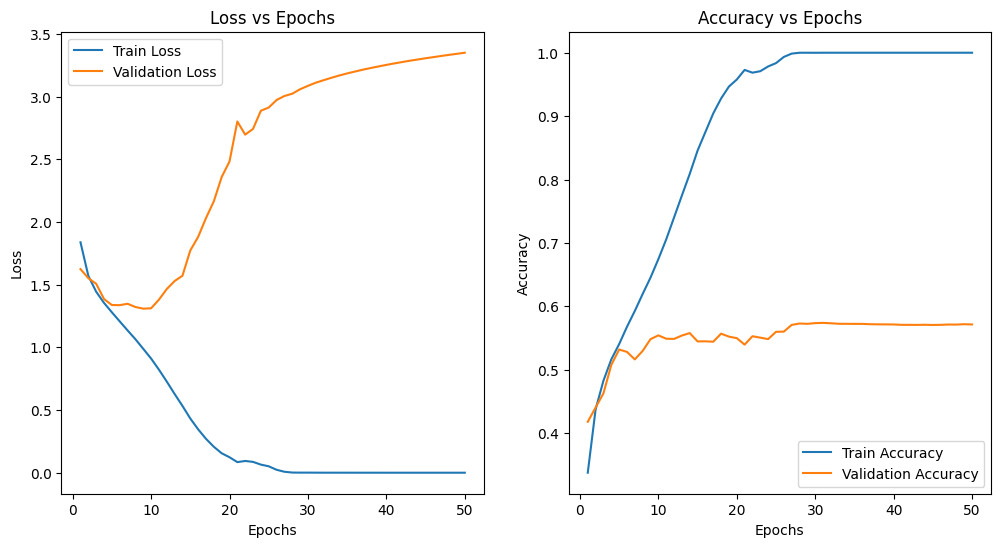

CPU times: user 28min 41s, sys: 5.51 s, total: 28min 47s
Wall time: 28min 43s


In [10]:
%%time
# 学習・評価の実行
train_eval()
